# Explore Activate Learning Results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import Counter
from collections import defaultdict
import numpy as np
import re
import seaborn as sns


sns.set(rc={"figure.figsize": (20, 10)}, style="whitegrid", font_scale=2)
cwd = os.getcwd()
plot_folder = os.path.join(cwd, "plots")
res_folder = os.path.join(cwd, "results")
print(f"Current working directory is: {cwd}")

Current working directory is: C:\Users\anton\Gitlab\huggingface\active_learning


## Comparison of Different Language Models
By training different embeddings on the same dataset, we can compare the performance of embeddings for different task.

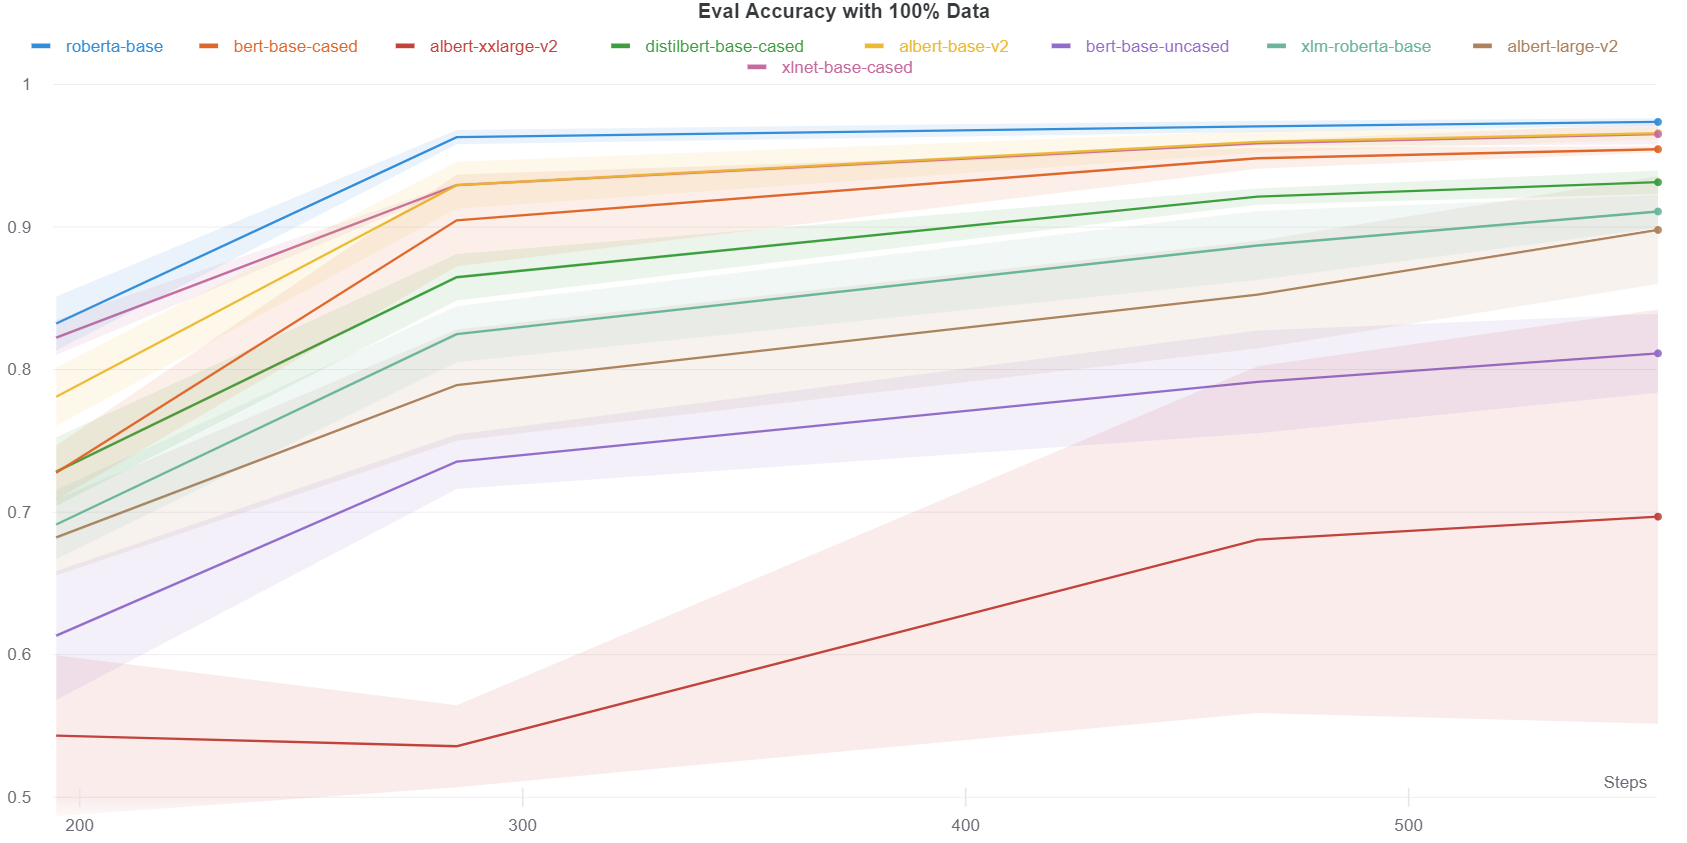

In [2]:
from IPython.display import Image

Image(filename=os.path.join(res_folder, "100Chart.png"))

We see that `roberta-base` performs best and is closely followed by `albert-base-v2` and `xlnet-base-cased`. The results are obtained with the default hyperparameters. But the performance of 97% seems about right.

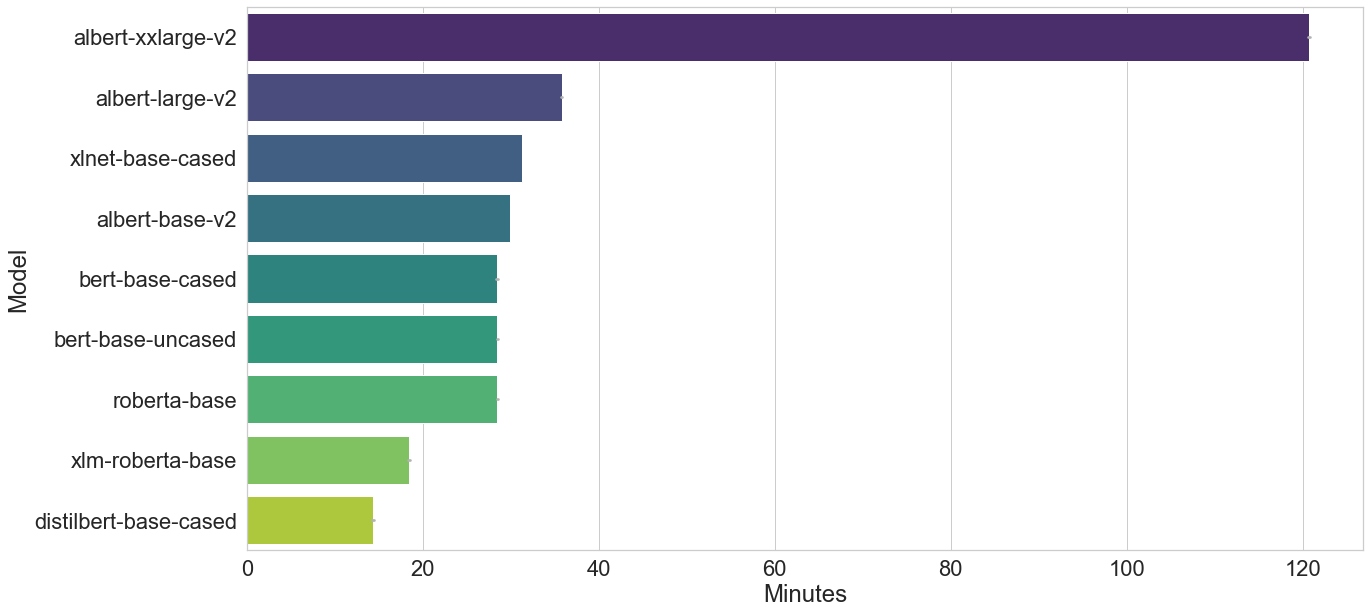

In [3]:
# Lets look at runtimes of them
df_100 = pd.read_csv(os.path.join(res_folder, "wandb_100.csv"))
df_100 = df_100.sort_values(["Runtime"], ascending=False).reset_index(drop=True)
df_100["Runtime_min"] = df_100["Runtime"].apply(lambda x: round(x / 60, 2))
df_100["model"] = df_100["wandb_name"].apply(lambda x: x.split("_")[-1])
ax = sns.barplot(x="Runtime_min", y="model", data=df_100, palette="viridis", errcolor='.7')
ax.set(xlabel="Minutes", ylabel="Model")
plt.savefig(os.path.join(plot_folder, "Runtimes.png"), bbox_inches="tight", dpi=300)

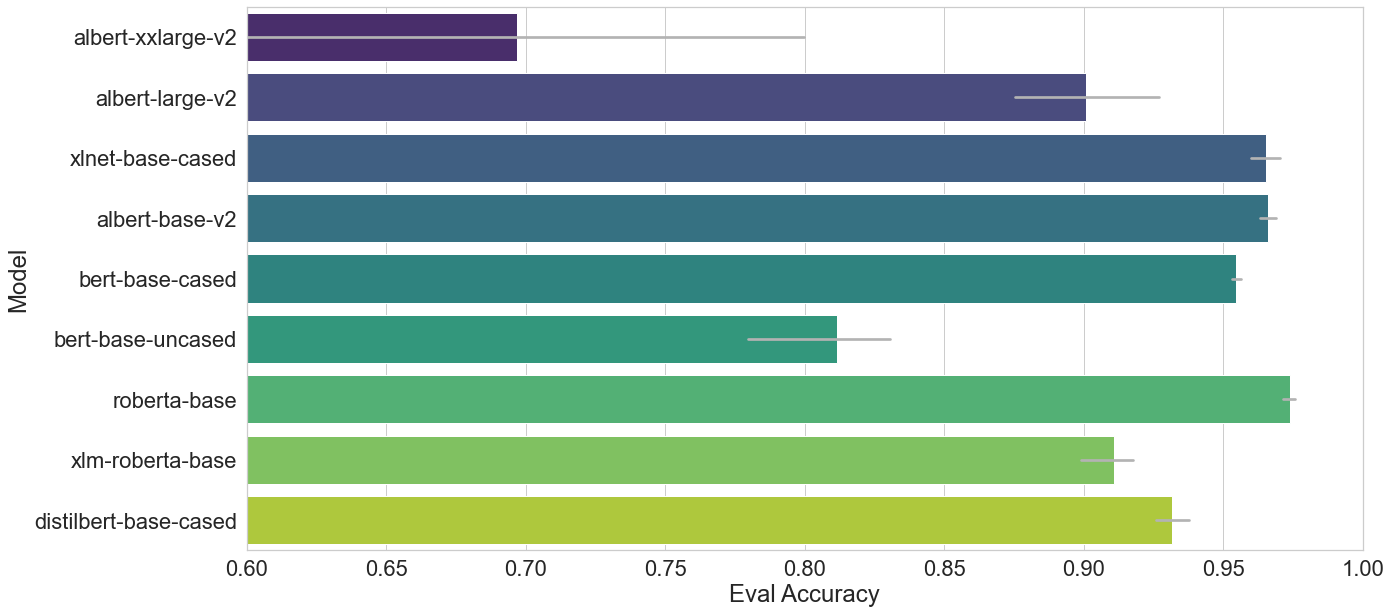

In [4]:
ax = sns.barplot(y="wandb_name", x="eval_acc", data=df_100, palette="viridis", errcolor='.7',)
ax.set(xlim=(0.6, 1))
ax.set(xlabel="Eval Accuracy", ylabel="Model")
plt.savefig(os.path.join(plot_folder, "100Accuracy.png"), bbox_inches="tight", dpi=300)

Runtimes are about half for `distilbert` (as expected) and `xlm-roberta-base` and too high for `albert-xxlarge-v2` which is clearly undertrained. Overall, our best three models also have good runtimes. 

# Baselines for Active Learning
Next, we look at the performance of the same models when trained on smaller random subsets. Due to long runtimes, we don't tune too many hyperparameters. As a good rule of thumb, we use the same number of training steps for any size of the dataset. Hyperparameters that would be worth exploring are learning rate and also weight decay. 

In [5]:
df = pd.read_csv(os.path.join(res_folder, "wandb_subsets.csv"))
df["model"] = df["wandb_name"].apply(lambda x: x.split("_")[-1])

# Let's add the 100% results at subset_size == 100
df_100["subset_size"] = 100
df = df.append(df_100)
df = df[df["State"] == "finished"]

df.head(2)

Name        ID                          Name.1  \
0  distilbert-base-cased_10onybb5  10onybb5  distilbert-base-cased_10onybb5   
1        bert-base-cased_1216tdlu  1216tdlu        bert-base-cased_1216tdlu   

      State Notes     User  Tags                   Created  Runtime  Sweep  \
0  finished     -  antonmu   NaN  2020-07-02T21:04:46.000Z      921    NaN   
1  finished     -  antonmu   NaN  2020-07-02T20:16:24.000Z     1725    NaN   

   ...             wandb_name  warmup_steps  weight_decay     epoch  eval_acc  \
0  ...  distilbert-base-cased         200.0           0.0  8.232877  0.915593   
1  ...        bert-base-cased         200.0           0.0  8.232877  0.945232   

  eval_loss  learning_rate.1      loss                  model Runtime_min  
0  0.374782          0.00002  0.237054  distilbert-base-cased         NaN  
1  0.240293          0.00002  0.098386        bert-base-cased         NaN  

[2 rows x 48 columns]

In [6]:
def ref_line(df):
    # We take the average acc of best model at 100%
    ax.axhline(
        df[(df["subset_size"] == 100)].groupby("model").mean()["eval_acc"].max(),
        ls="--",
        c="orange",
        alpha=0.9,
    )

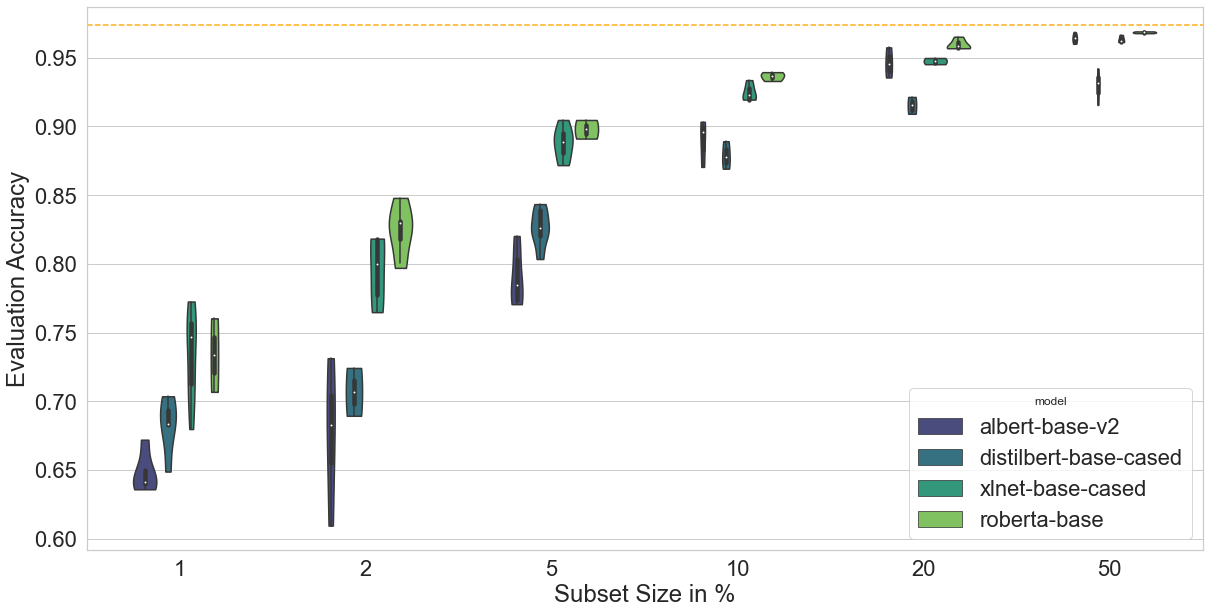

In [7]:
plt.figure()
sel_subset_size = [1, 2, 5,10,20,50]
sel_models = [
    "albert-base-v2",
    "distilbert-base-cased",
    "xlnet-base-cased",
    "roberta-base",
    #     "xlm-roberta-base",
    #     "bert-base-cased",
    #     "albert-large-v2",
    #     "bert-base-uncased",
]
ax = sns.violinplot(
    cut=0,
    x="subset_size",
    y="eval_acc",
    hue="model",
    hue_order=sel_models,
    palette = 'viridis',
    width = .5,
    data=df[df["model"].isin(sel_models) & df["subset_size"].isin(sel_subset_size)],
    
)
ref_line(df)
ax.set(xlabel="Subset Size in %", ylabel="Evaluation Accuracy")
plt.savefig(os.path.join(plot_folder, "Violins.png"), bbox_inches="tight", dpi=300)

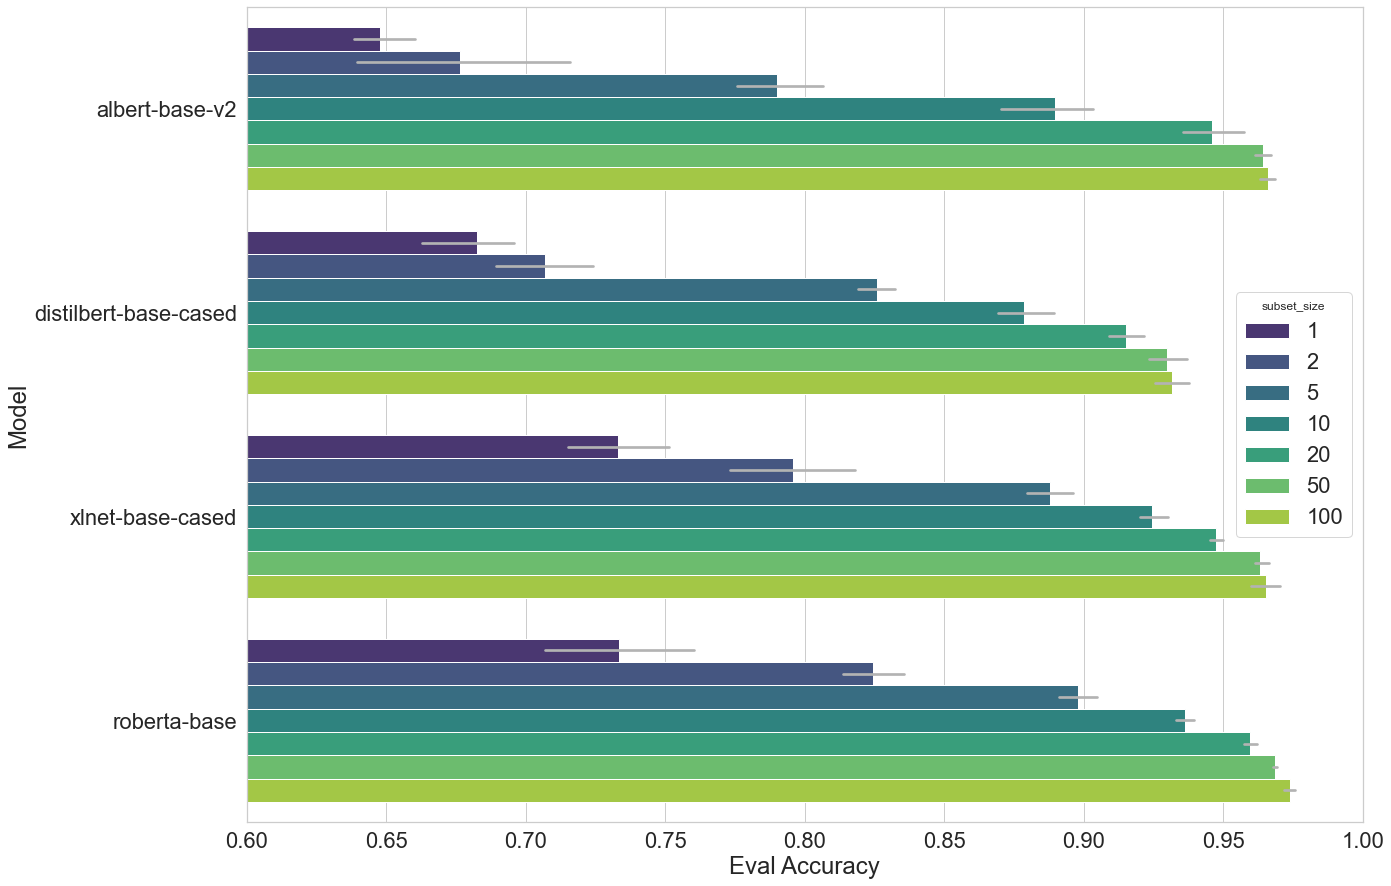

In [8]:
sns.set(rc={"figure.figsize": (20, 15)}, style="whitegrid", font_scale=2)
ax = sns.barplot(
    y="wandb_name",
    x="eval_acc",
    order=sel_models,
    hue="subset_size",
    data=df[df["model"].isin(sel_models)],
    palette="viridis",
    errcolor='.7',
)
ax.set(xlim=(0.6, 1))
ax.set(xlabel="Eval Accuracy", ylabel="Model")
plt.savefig(os.path.join(plot_folder, "Subsets.png"), bbox_inches="tight", dpi=300)